# Data processing for global correlation wavefield

This is the Jupyter notebook in supplement to the main article in Earth-Science Reviews *The Earth's coda correlation wavefield: Rise of the new paradigm and recent advances*.

Please cite at least of one of the following article if you use a part or entire code in your research:
- H. Tkalčić, T.-S. Phạm and S. Wang, The Earth's coda correlation wavefield: Rise of the new paradigm and recent advances, Earth-Science Reviews, 208, doi:10.1016/j.earscirev.2020.103285, 2020.

- Phạm T.-S., H. Tkalčić, M. Sambridge, and B. L. N. Kennett, Earth's correlation wavefield: Late coda correlation, Geophys. Res. Lett., 45 (7),  doi:10.1002/2018GL077244, 2018.

- Tkalčić, H. and T.-S. Phạm, Shear properties of the Earth's inner core revealed by a detection of J waves in global correlation wavefield, Science, 362, doi:10.1126/science.aau7649, 2018.

Canberra, July 2020  
*Dr T. Son Pham*  
thanhson.pham@anu.edu.au

## Import neccessary libraries

Most libraries used in the package are built-in: *number, glob, os, time, multiprocessing, threading, warnings*. Additionally, users might need to install the following packages: *obspy, pyfftw, NetCDF4*.  
https://github.com/obspy/obspy/wiki  
https://pypi.org/project/pyFFTW/  
http://unidata.github.io/netcdf4-python/netCDF4/index.html  

For new Python users, we encourage the use of Anaconda (https://www.anaconda.com) to manage their software packages. Once Anaconda is installed, the above packages can be installed by executing the following command in their terminal:  
*conda install obspy pyfftw netcdf4*  

Finally, *libgcc* contains important supporting functions and is included in this package.

In [1]:
## Build-in libraries
import multiprocessing as mp
import threading
import numpy as np
import os
import time
import warnings
from obspy import UTCDateTime
from obspy.geodetics import locations2degrees

## Supporting functions for global cross-correlation
import libgcc

/Users/thanhson/anaconda3/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


## Pre-determined parameters

Fixed parameters are used in different stages of the program.

In [2]:
## Coda time window from the event origin time (in seconds)
window_start, window_end = 10000, 35000

## Temporal normalization prameters
# Pre-filter period band used in the computation of the normalization weight
ram_fband = (0.02, 0.067) # seconds
# Window width of the running absolute-mean temporal normalization
temp_width = 128 # seconds

## Spectral normalization parameter: width of the normalization
spec_width = 2e-3 # Hz

## Number of parallel processors used in parallel
nprocs = 4

## Pre-determined size of inter-receiver bin
bin_size = 1 # degrees

## Directory of merged waveforms
path_name = 'Data/Event_2017.01.22.04.30.22.990'

## 1. Read coda waveforms

Read coda waveforms stored in SAC format. Origin time extracted from the directory name and time window to trim coda window.

In [3]:
## Wildcast of the waveform file names
wildcast = os.path.join(path_name, '*.SAC')
## String determine the event origin time
eventstr = os.path.basename(path_name)
## Get origin time from the eventstr
origintime = UTCDateTime().strptime(eventstr, 'Event_%Y.%m.%d.%H.%M.%S.%f')

start = time.time()
data_stream = libgcc.ReadData(wildcast, origintime, window_start, window_end-window_start)
end = time.time()
delta = data_stream[0].stats.delta
ntraces = len(data_stream)

print ('Read in coda waveform')
print ('> Coda time window: %d - %d s after the origin time' % \
    (window_start, window_end))
print ('> Sampling rate: %.2f sps' % (1 / delta))
print ('> Number of seismograms: %d' % ntraces)
print ('> Reading time: %.2f s\n' % (end-start))

Read in coda waveform
> Coda time window: 10000 - 35000 s after the origin time
> Sampling rate: 2.00 sps
> Number of seismograms: 1457
> Reading time: 7.04 s



## 2. Initialize pre-processors

Initilize GCC pre-processors instances to do data processing in the next step.

In [4]:
#### Initialization of GCC processors

## Number of waveform points pre-determined from window range and sampling time delta
npts = int(np.round((window_end - window_start) / delta))
## Number of points in the FFT transform traces, which is double 
fft_npts = 2 * npts
## Intialization 
start = time.time()
xcc = list()
for ii in range(nprocs):
    xcc.append(libgcc.GCC(fft_npts, temp_width, spec_width, ram_fband))
end = time.time()

print ('Initializing %d GCC processors:' % nprocs)
print ('> npts:', npts)
print ('> fft npts:', fft_npts)
print ('> Temporal normalization - width: %.1f s' % temp_width)
print ('                         - weight bandpass: %.3f - %.3f Hz' % ram_fband)
print ('> Spectral normalization (whitening): %.1f mHz' % (spec_width * 1e3))
print ('> Initalizing time: %.3f s\n' % (end-start))

Initializing 4 GCC processors:
> npts: 50000
> fft npts: 100000
> Temporal normalization - width: 128.0 s
                         - weight bandpass: 0.020 - 0.067 Hz
> Spectral normalization (whitening): 2.0 mHz
> Initalizing time: 0.018 s



## 3. Perform single-station waveform pre-processing

Pre-process waveform data using individual pre-processors in parallel processors. Whitened spectra are stored in a continuous block of memory what is shared among processors.

In [5]:
#### Preprocessing of single-station waveforms that include temporal and spectral normalization
def pre_proc(my_xcc, my_stream, my_indices, output_real, output_imag):
    spec_npts = my_xcc.get_spec_npts()
    for ii, tr in zip(my_indices, my_stream):
        try:
            # pre-process job
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")            
                spec = my_xcc.pre_proc(tr)
            # assign to global data
            if np.all(np.isfinite(spec)):
                output_real[ii*spec_npts:(ii+1)*spec_npts] = np.real(spec)
                output_imag[ii*spec_npts:(ii+1)*spec_npts] = np.imag(spec)
        except Exception as ex: 
            pass #print (ex)

#### Preprocessing of waveform data ####
## Declare a common memory block to be shared by different processors.
## Pre-processed spectral traces are stored in the memory block array.
spec_real = mp.Array('f', ntraces*xcc[0].get_spec_npts(), lock=False)
spec_imag = mp.Array('f', ntraces*xcc[0].get_spec_npts(), lock=False)

## Preprocessing in paralallel at multiple processors
## Results are stored in the shared memory block
print ('Pre-processing with %d workers' % nprocs)
start = time.time()
jobs = list()
for ii in range(nprocs):
    my_indices = np.arange(ii, ntraces, nprocs)
    p = mp.Process(target=pre_proc, 
        args=(xcc[ii], data_stream[ii:ntraces:nprocs], my_indices, spec_real,spec_imag))
    p.start()
    jobs.append(p)
for p in jobs: p.join()
end = time.time()

## Converting the memory block (1D) in to 2D numpy array of complex numbers.
spec_data = np.array(spec_real[:]) + np.array(spec_imag[:]) * 1j
spec_data = spec_data.reshape((ntraces, xcc[0].get_spec_npts()))
print ('> Runtime (multi-threading): %.2f s\n' % (end-start))

Pre-processing with 4 workers
> Runtime (multi-threading): 100.97 s



## 4. Pre-compute inter-receiver histogram

We use station latitudes and longitudes in SAC headers to compute station inter-receiver distances and arange them into distance bins.

In [6]:
#### Based on latitudes and longitudes of the existing station
## pre-compute inter-receiver distance pairs
lats = [tr.stats.sac.stla for tr in data_stream]
lons = [tr.stats.sac.stlo for tr in data_stream]

print ('Computing station pairs:')
print ('> Interstation distance bin_size:', bin_size, 'deg')
## bulding look-up table for inter-station bins
nbins = int(180. / bin_size)
npairs = int((ntraces * (ntraces + 1)) / 2)
cc_pairs = np.zeros((npairs, 3), dtype=int)
pair_hist = np.zeros(nbins, dtype=int)
start = time.time()
count = 0
for s1 in range(ntraces):
    for s2 in range(s1, ntraces):
        gcarc = locations2degrees(lats[s1], lons[s1], lats[s2], lons[s2])
        nb = int(np.round(gcarc / bin_size))
        nb = (nbins - 1) if nb >= nbins else nb
        cc_pairs[count, :] = [s1, s2, nb]
        pair_hist[nb] += 1
        count += 1
end = time.time()
print ('> Number of pairs: %d' % npairs)
print ('> Runtime (serial): %.2f s\n' % (end-start))

Computing station pairs:
> Interstation distance bin_size: 1 deg
> Number of pairs: 1062153
> Runtime (serial): 47.73 s



## 5. Compute and stack cross-correlation in frequency domain

Compute cross-correlation in the frequency domain, which is the multiplication of one spectrum with the complex conjugate of the other. The computed cross-correlation is stacked in to pre-determined bin in the previous step.

In [7]:
#### Compute and stack cross-correlation in frequency domain

def calc_spec_xcorr(my_pairs, spec_data, safe_lock, spec_stack):
    # local buffer of cross-correlogram
    local_spec_cc = np.zeros((nbins, spec_data.shape[1]), dtype='complex64')
    # cross-correlating and stacking in spectral domain
    for ii in range(my_pairs.shape[0]):
        s1, s2, nb = my_pairs[ii, :]
        spec1 = spec_data[s1]
        spec2 = spec_data[s2]
        local_spec_cc[nb, :] += spec1 * np.conj(spec2)
    # stack to global buffer
    safe_lock.acquire()
    spec_stack += local_spec_cc
    safe_lock.release()

# global buffer of cross-correlogram
spec_stack = np.zeros((nbins, xcc[0].get_spec_npts()), dtype='complex64');
safe_lock = threading.Lock()
## multi-processing
print ('Cross-correlating with %d workers ...' % nprocs)
start = time.time()
jobs = []
for ii in range(nprocs):
    my_pairs = cc_pairs[ii:count:nprocs, :]
    p = threading.Thread(target=calc_spec_xcorr, 
        args=(my_pairs, spec_data, safe_lock, spec_stack))
    p.start()
    jobs.append(p)
for p in jobs: p.join()
end = time.time()
print ('> Runtime (multi-threading): %.2f s\n' % (end-start))

Cross-correlating with 4 workers ...
> Runtime (multi-threading): 113.32 s



## 6. Inverse FFT of stacked frequency correlogram

Inverse Fourier Transform of the stacked spectrum correlogram to time domain. The cross-correlation in time domain is folded at 0 time to form a symmetric cross-correlation.

In [8]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++#
#++++++++++++++++ INVERSE FFT AND CREATE CC +++++++++++++++++++#
# buffer for cross-correlogram in time domain
corrwf = np.zeros((nbins, npts), dtype='float32')
print ('Inverse FFT')
start = time.time()
for nb in range(nbins):
    spec = spec_stack[nb, :]
    cc = xcc[0].inv_rfft(spec)
    sym_cc = 0.5 * (cc + cc[::-1])
    corrwf[nb, :] = sym_cc[0:npts]
end = time.time()
print ('> Runtime (serial): %.2f s' % (end-start))

Inverse FFT
> Runtime (serial): 0.09 s


## 8. Plot correlogram

Visualize the computed correlogram as a two-dimensional image alongside with the inter-receiver histogram.

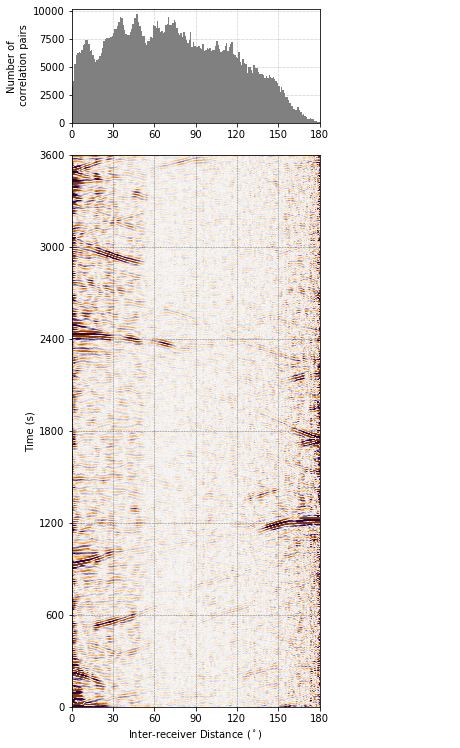

In [9]:
#### Plot computed event correlogram

import matplotlib.pyplot as plt
import libgcc

xmin, xmax = 0, 180
xstep = 30
ymin, ymax = 0, 3600
ystep = 600
# ########### 01 READ IN CORRELOGRAM ###########
nbins, npts = corrwf.shape
imag = libgcc.NormalizeFilter(corrwf.copy(), pair_hist, delta, 15, 50)

VMAX = 2e-2 * np.max(np.abs(imag))
# imag[imag>VMAX] = VMAX
# imag[imag<-VMAX] = -VMAX

########### 02 READ IN CORRELOGRAM ###########
fig = plt.figure(figsize=(6.5, 10.5))
gs = fig.add_gridspec(5, 3)
ax = fig.add_subplot(gs[1:5, 0:2])
axHist = fig.add_subplot(gs[0, 0:2], sharex=ax)
axKey = fig.add_subplot(gs[0:5, 2], xticks=[], yticks=[], frameon=False)

########### 03 DISPLAY CORRELOGRAM ###########
time_max = npts * delta
ax.imshow(imag.T, vmax=VMAX, vmin=-VMAX, aspect='auto', cmap='PuOr',
    extent=(0, 180, time_max, 0), interpolation='sinc')
ax.grid(ls='--', color='k', lw=0.5, alpha=0.5)
xticks = np.arange(xmin, xmax+1, xstep).astype(int)
ax.set_xticks(xticks)
ax.set_xlabel('Inter-receiver Distance ($^\circ$)')
yticks = np.arange(ymin, ymax+1, ystep).astype(int)
ax.set_yticks(yticks)
ax.set_ylim(ymin, ymax)
ax.set_ylabel('Time (s)')

########### 04 PLOT PREDICTION ###########
# if with_prediction: 
#     try:
#         plot_prediction(ax, axKey, taup_curve_fname, prediction_fname, linestyle)
#     except Exception as ex:
#         print (ex)

########### 05 PLOT HISTOGRAM ###########
axHist.bar((np.arange(nbins)+0.5)*bin_size, pair_hist, width=1.0, color='gray')
axHist.set_ylabel('Number of\n correlation pairs')
axHist.set_xlim(xmin, xmax)    
axHist.grid(ls=':', color='gray', lw=.5)

## Stretch layout and save figures
gs.tight_layout(figure=fig)
plt.savefig('Output/EventCorrelogram.pdf')
plt.show()